In [83]:
import torch
import os
import json

dataset_path = '/kaggle/input/bestest-dataset-version-12'
# dataset_path = '/kaggle/input/final-model'

checkpoint_path = os.path.join(dataset_path, 'checkpoint.pth')

model_path = os.path.join(dataset_path, 'model_best.pth')

model_weights = torch.load(model_path, map_location="cpu")

checkpoint = torch.load(checkpoint_path, map_location="cpu", weights_only=False)

In [84]:
# View available keys
print("Checkpoint Keys:", checkpoint.keys())

# View some values
print("\nEpoch:", checkpoint['epoch'])
print("Best Validation Loss:", checkpoint['best_val_loss'])

# Optional: See training history
history = checkpoint['history']
print("\nTrain Loss History:", history['train_loss'])
print("\nValidation Loss History:", history['val_loss'])

Checkpoint Keys: dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'best_val_loss', 'history', 'prev_val_task_losses'])

Epoch: 64
Best Validation Loss: 0.030824661828004397

Train Loss History: [3.3101953165284517, 3.059542854284418, 2.931765289142214, 2.8241564744505387, 2.394790416133815, 2.242197161090785, 2.1232014401205657, 2.107552695890953, 2.0515086948871613, 1.9837696428956657, 1.7865283499503959, 1.6474488655041004, 1.5819520359409267, 1.5176485967019508, 1.5124818215082432, 1.5244558422729886, 1.3048822252914822, 1.2862048205630532, 1.298477096290424, 1.232327490531165, 1.1463741017826672, 1.029067679212011, 1.0281413639413899, 1.1009112321611108, 1.0584801245352318, 0.9419968254093466, 0.9014597167742664, 0.901141464453319, 0.7409724904031589, 0.7152556527791352, 0.7280591109703327, 0.589524564558062, 0.6012466269834288, 0.5705675767927334, 0.8055924626773802, 0.7509585608696115, 0.6982508931180527, 0.5878101106861542, 0.62469321026884

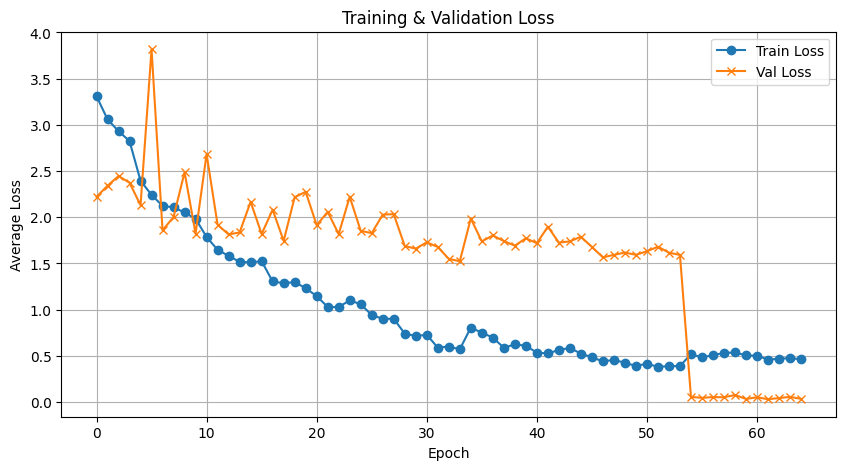

In [86]:
import matplotlib.pyplot as plt

# Extract average loss (float) from each epoch's (avg_loss, task_loss_dict) tuple
train_avg_losses = [t[0] if isinstance(t, tuple) else t for t in history['train_loss']]
val_avg_losses = [v[0] if isinstance(v, tuple) else v for v in history['val_loss']]

plt.figure(figsize=(10, 5))
plt.plot(train_avg_losses, label='Train Loss', marker='o')
plt.plot(val_avg_losses, label='Val Loss', marker='x')
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [87]:
preds_path = os.path.join(dataset_path, "model_upload/preds_targets.json")
with open(preds_path, "r") as f:
    preds_targets = json.load(f)

# preds_targets keys depend on what you saved (e.g., 'predictions', 'labels')
print("Loaded preds and targets keys:", preds_targets.keys())

Loaded preds and targets keys: dict_keys(['bowel', 'extra', 'liver', 'kidney', 'spleen'])


In [88]:
metrics_path = os.path.join(dataset_path, "model_upload/test_metrics.json")
with open(metrics_path, "r") as f:
    test_metrics = json.load(f)

print("Loaded test metrics:", test_metrics)

Loaded test metrics: {'loss': 2.0127606758704553}


In [89]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

def compute_metrics_from_preds_targets(preds_targets, organ_types, threshold=0.5):
    """
    Compute metrics (precision, recall, F1, accuracy, ROC AUC) for each organ.

    Args:
        preds_targets (dict): organ -> {'preds': np.array, 'labels': np.array}
            For binary: preds can be probabilities or binary predictions
            For multi-class: preds can be either probabilities with shape (N, num_classes)
                            or predicted class indices with shape (N,)
        organ_types (dict): organ -> 'binary' or 'multi'
        threshold (float): threshold for binary classification

    Returns:
        dict: organ -> metrics dict
    """
    results = {}

    for organ, data in preds_targets.items():
        preds = np.array(data['preds'])
        labels = np.array(data['labels']).astype(int)

        if organ not in organ_types:
            print(f"[Warning] Organ '{organ}' not in organ_types dict, skipping")
            continue

        organ_type = organ_types[organ]

        if organ_type == 'binary':
            if preds.ndim == 1 or (preds.ndim == 2 and preds.shape[1] == 1):
                preds_flat = preds.flatten()
                if preds_flat.dtype != int and ((preds_flat >= 0).all() and (preds_flat <= 1).all()):
                    bin_preds = (preds_flat >= threshold).astype(int)
                else:
                    bin_preds = preds_flat.astype(int)
            else:
                print(f"[Warning] Unexpected preds shape for binary organ '{organ}': {preds.shape}, skipping")
                continue

            precision, recall, f1, _ = precision_recall_fscore_support(
                labels, bin_preds, average='binary', zero_division=0
            )
            accuracy = accuracy_score(labels, bin_preds)

            try:
                roc_auc = roc_auc_score(labels, preds_flat)
            except Exception as e:
                print(f"[Warning] ROC AUC failed for binary '{organ}': {e}")
                roc_auc = None

            results[organ] = {
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'accuracy': accuracy,
                'roc_auc': roc_auc,
            }

        elif organ_type == 'multi':
            # Handle predicted class indices or probability vectors
            if preds.ndim == 2 and preds.shape[1] > 1:
                # preds are probabilities/logits, take argmax for class predictions
                class_preds = np.argmax(preds, axis=1)
            elif preds.ndim == 1:
                # preds are already class indices
                class_preds = preds
            else:
                print(f"[Warning] Unexpected preds shape for multi-class organ '{organ}': {preds.shape}, skipping")
                results[organ] = {
                    'precision': None,
                    'recall': None,
                    'f1_score': None,
                    'accuracy': None,
                    'roc_auc': None,
                }
                continue

            precision, recall, f1, _ = precision_recall_fscore_support(
                labels, class_preds, average='macro', zero_division=0
            )
            accuracy = accuracy_score(labels, class_preds)

            try:
                if preds.ndim == 2 and preds.shape[1] > 1:
                    num_classes = preds.shape[1]
                    classes = np.arange(num_classes)
                    labels_one_hot = label_binarize(labels, classes=classes)

                    if labels_one_hot.shape[1] != preds.shape[1]:
                        pad_width = preds.shape[1] - labels_one_hot.shape[1]
                        labels_one_hot = np.pad(labels_one_hot, ((0, 0), (0, pad_width)), mode='constant')

                    roc_auc = roc_auc_score(labels_one_hot, preds, multi_class='ovo')
                else:
                    # No probabilities for ROC AUC calculation
                    print(f"[Info] ROC AUC skipped for multi-class organ '{organ}' because probabilities not available.")
                    roc_auc = None
            except Exception as e:
                print(f"[Warning] ROC AUC failed for multi-class '{organ}': {e}")
                roc_auc = None

            results[organ] = {
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'accuracy': accuracy,
                'roc_auc': roc_auc,
            }

        else:
            print(f"[Warning] Unknown organ type '{organ_type}' for organ '{organ}', skipping")

    return results

In [90]:
organ_types = {
    'bowel': 'binary',
    'extra': 'binary',
    'liver': 'multi',
    'kidney':'multi',
    'spleen': 'multi',
}

metrics = compute_metrics_from_preds_targets(preds_targets, organ_types)

[Info] ROC AUC skipped for multi-class organ 'liver' because probabilities not available.
[Info] ROC AUC skipped for multi-class organ 'kidney' because probabilities not available.
[Info] ROC AUC skipped for multi-class organ 'spleen' because probabilities not available.


/tmp/ipykernel_36/2198611238.py:7: RuntimeWarning: Mean of empty slice
  metric: np.nanmean([


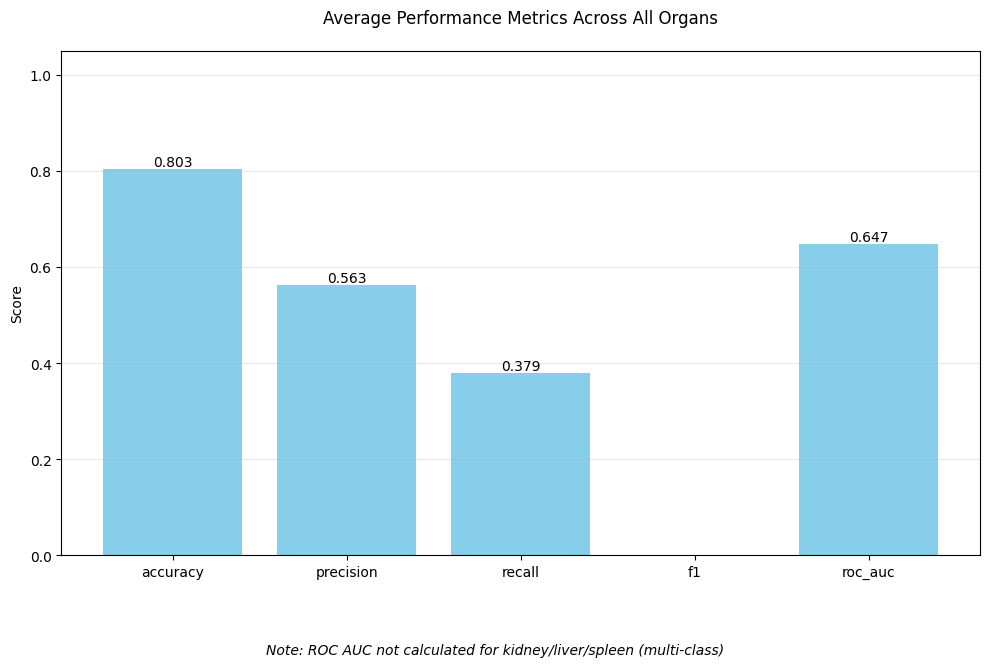

In [91]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate averages (ignoring NaN and None values)
metric_names = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
averages = {
    metric: np.nanmean([
        metrics[organ].get(metric, np.nan) 
        for organ in metrics 
        if metrics[organ].get(metric) is not None  # Exclude None values
    ])
    for metric in metric_names
}

# Create the plot
plt.figure(figsize=(10, 6))
bars = plt.bar(metric_names, [averages[m] for m in metric_names], color='skyblue')

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

# Customize the plot
plt.title('Average Performance Metrics Across All Organs', pad=20)
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.grid(axis='y', alpha=0.3)

# Add explanation
plt.figtext(0.5, -0.1, 
           "Note: ROC AUC not calculated for kidney/liver/spleen (multi-class)",
           ha="center", fontsize=10, style='italic')

plt.tight_layout()
plt.show()


=== BOWEL ===
Confusion Matrix Values:
[[387   6]
 [ 10   8]]

Class Distribution:
Actual counts: {'Negative': 393, 'Positive': 18}
Predicted counts: {'Negative': 397, 'Positive': 14}
Saved to /kaggle/working/confusion_matrices/bowel_confusion_matrix.png


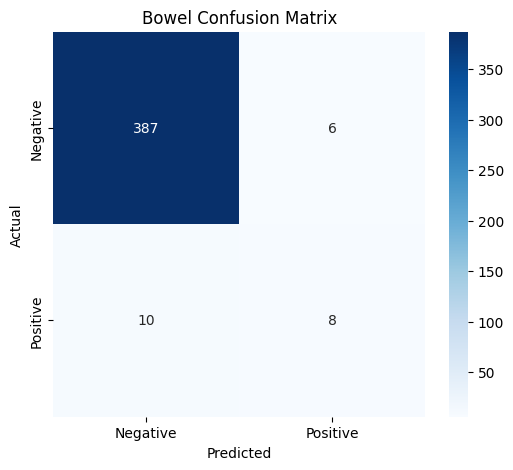


=== EXTRA ===
Confusion Matrix Values:
[[335  22]
 [ 42  12]]

Class Distribution:
Actual counts: {'Negative': 357, 'Positive': 54}
Predicted counts: {'Negative': 377, 'Positive': 34}
Saved to /kaggle/working/confusion_matrices/extra_confusion_matrix.png


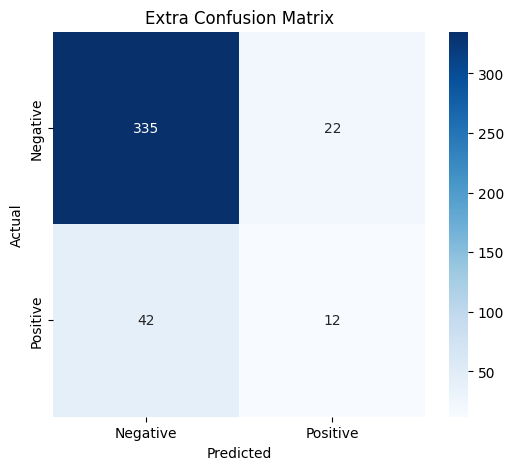


=== LIVER ===
Confusion Matrix Values:
[[199 132   0]
 [ 32  32   0]
 [ 12   3   1]]

Class Distribution:
Actual counts: {'Healthy': 331, 'Low': 64, 'High': 16}
Predicted counts: {'Healthy': 243, 'Low': 167, 'High': 1}
Saved to /kaggle/working/confusion_matrices/liver_confusion_matrix.png


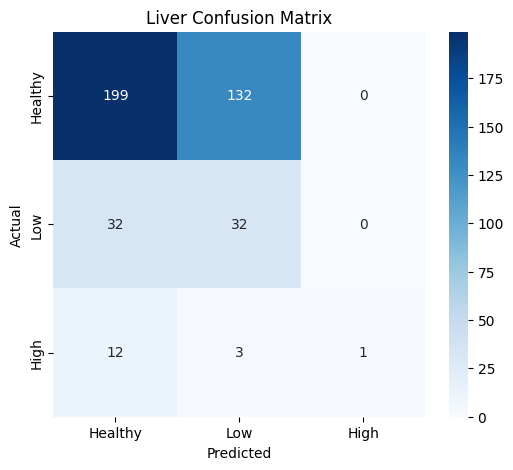


=== KIDNEY ===
Confusion Matrix Values:
[[345   8   2]
 [ 32   4   0]
 [ 13   3   4]]

Class Distribution:
Actual counts: {'Healthy': 355, 'Low': 36, 'High': 20}
Predicted counts: {'Healthy': 390, 'Low': 15, 'High': 6}
Saved to /kaggle/working/confusion_matrices/kidney_confusion_matrix.png


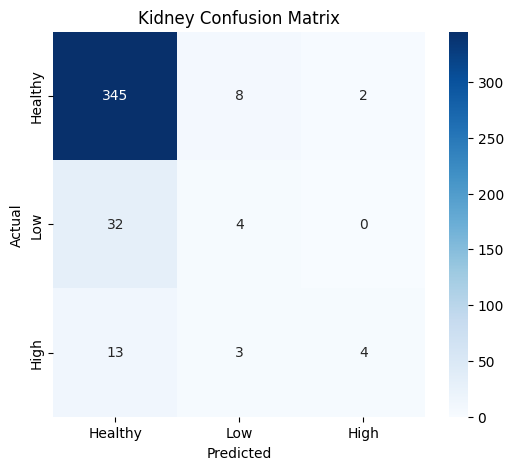


=== SPLEEN ===
Confusion Matrix Values:
[[312   6   4]
 [ 45   8   0]
 [ 31   1   4]]

Class Distribution:
Actual counts: {'Healthy': 322, 'Low': 53, 'High': 36}
Predicted counts: {'Healthy': 388, 'Low': 15, 'High': 8}
Saved to /kaggle/working/confusion_matrices/spleen_confusion_matrix.png


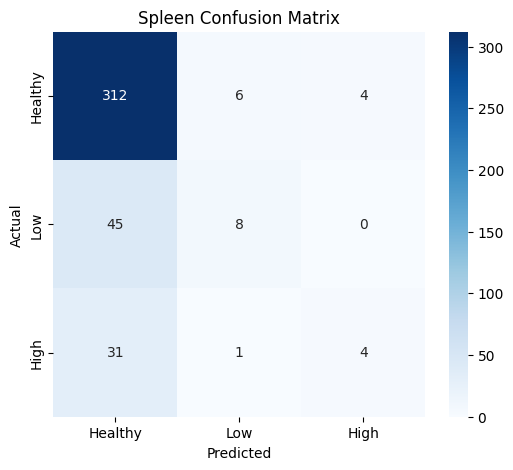

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

def plot_save_and_print_confusion_matrices(preds_targets, organ_types):
    # Create output directory
    output_dir = '/kaggle/working/confusion_matrices'
    os.makedirs(output_dir, exist_ok=True)
    
    for organ in organ_types.keys():
        try:
            # Get data
            preds = preds_targets[organ]['preds']
            labels = preds_targets[organ]['labels']
            
            # Set class names
            if organ_types[organ] == 'binary':
                classes = ['Negative', 'Positive']
            else:  # multi-class
                classes = ['Healthy', 'Low', 'High']
            
            # Compute confusion matrix
            cm = confusion_matrix(labels, preds)
            
            # PRINT NUMERICAL VALUES
            print(f"\n=== {organ.upper()} ===")
            print("Confusion Matrix Values:")
            print(cm)
            print("\nClass Distribution:")
            print("Actual counts:", {cls: count for cls, count in zip(classes, cm.sum(axis=1))})
            print("Predicted counts:", {cls: count for cls, count in zip(classes, cm.sum(axis=0))})
            
            # Create and save figure FIRST
            fig = plt.figure(figsize=(6, 5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                      xticklabels=classes, yticklabels=classes)
            plt.title(f'{organ.capitalize()} Confusion Matrix')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            
            # Save before showing
            output_path = os.path.join(output_dir, f'{organ}_confusion_matrix.png')
            fig.savefig(output_path, bbox_inches='tight', dpi=300)
            print(f"Saved to {output_path}")
            
            # Then display
            plt.show()
            
            # Close figure after display
            plt.close(fig)
            
        except KeyError as e:
            print(f"\nSkipping {organ} - missing data: {e}")

# Example usage:
organ_types = {
    'bowel': 'binary',
    'extra': 'binary',
    'liver': 'multi',
    'kidney': 'multi',
    'spleen': 'multi',
}

plot_save_and_print_confusion_matrices(preds_targets, organ_types)

/tmp/ipykernel_36/1154125431.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(metrics_to_plot))


[✔] Plot saved to average_metrics_all_metrics_together.png


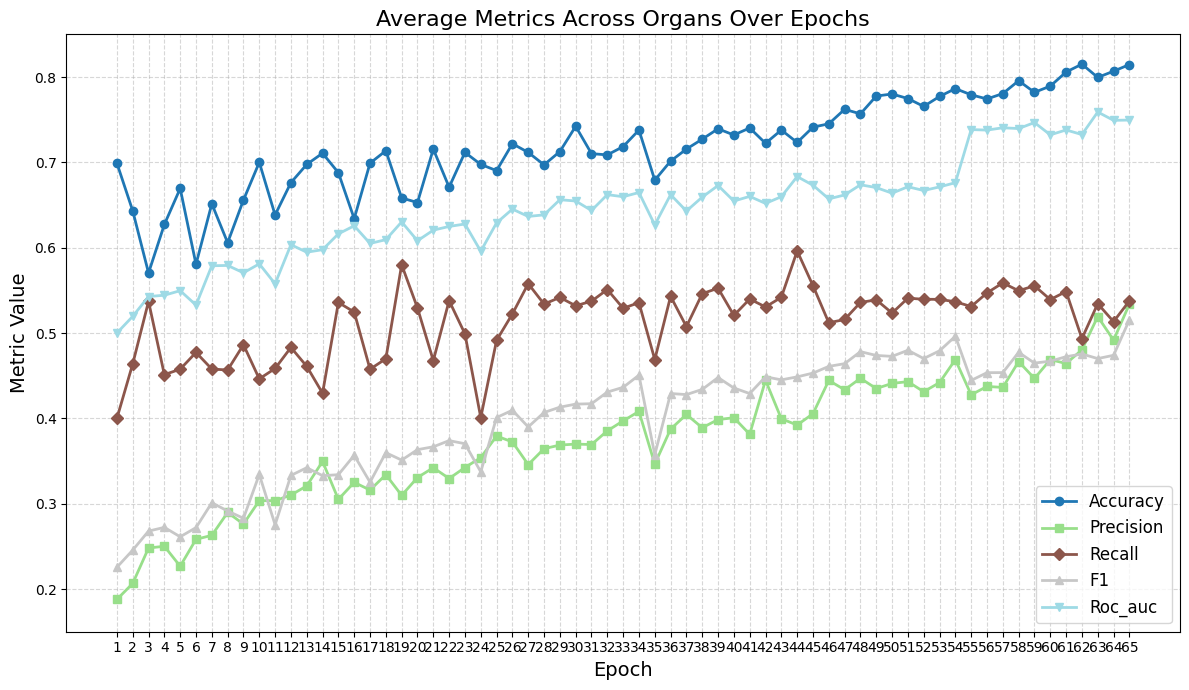


Average metric values every 5 epochs (plus epoch 54 if available):


In [93]:
import matplotlib.pyplot as plt
import numpy as np

def plot_average_metrics_over_epochs(history, metrics_to_plot=None, save_path=None, log_interval=5):
    organs = list(history['metrics'].keys())

    if metrics_to_plot is None:
        metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

    # Determine number of epochs from first available metric of first organ
    num_epochs = None
    for organ in organs:
        for metric in metrics_to_plot:
            metric_vals = history['metrics'][organ].get(metric, None)
            if metric_vals:
                num_epochs = len(metric_vals)
                break
        if num_epochs:
            break
    if not num_epochs:
        print("[!] No metric data found.")
        return

    plt.figure(figsize=(12, 7))

    cmap = plt.cm.get_cmap('tab20', len(metrics_to_plot))
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'P', 'X', '*']

    avg_metrics_per_epoch = {metric: [] for metric in metrics_to_plot}

    for i, metric in enumerate(metrics_to_plot):
        avg_values = []
        for epoch in range(num_epochs):
            epoch_vals = []
            for organ in organs:
                vals = history['metrics'][organ].get(metric, [])
                if len(vals) > epoch:
                    epoch_vals.append(vals[epoch])
            avg = np.mean(epoch_vals) if epoch_vals else 0.0
            avg_values.append(avg)
            avg_metrics_per_epoch[metric].append(avg)

        plt.plot(
            range(1, num_epochs + 1),
            avg_values,
            marker=markers[i % len(markers)],
            label=metric.capitalize(),
            color=cmap(i),
            linewidth=2,
            markersize=6,
        )

    plt.title("Average Metrics Across Organs Over Epochs", fontsize=16)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Metric Value", fontsize=14)
    plt.ylim(0.15, 0.85)
    plt.xticks(range(1, num_epochs + 1))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"[✔] Plot saved to {save_path}")

    plt.show()

    # Log average metric values every log_interval epochs + always epoch 54 if in range
    epochs_to_log = list(range(0, num_epochs, log_interval))
    if 53 < num_epochs and 53 not in epochs_to_log:  # 53 because 0-based index for epoch 54
        epochs_to_log.append(53)
        epochs_to_log = sorted(epochs_to_log)

    print(f"\nAverage metric values every {log_interval} epochs (plus epoch 54 if available):")
    # for epoch in epochs_to_log:
    #     print(f"\nEpoch {epoch + 1}:")
    #     for metric in metrics_to_plot:
    #         value = avg_metrics_per_epoch[metric][epoch]
    #         print(f"  {metric.capitalize()}: {value:.4f}")

# Usage example:
plot_average_metrics_over_epochs(history, save_path="average_metrics_all_metrics_together.png", log_interval=5)


--- ACCURACY ---
Final Epoch (64): 0.8146
Best Epoch  (61): 0.8150


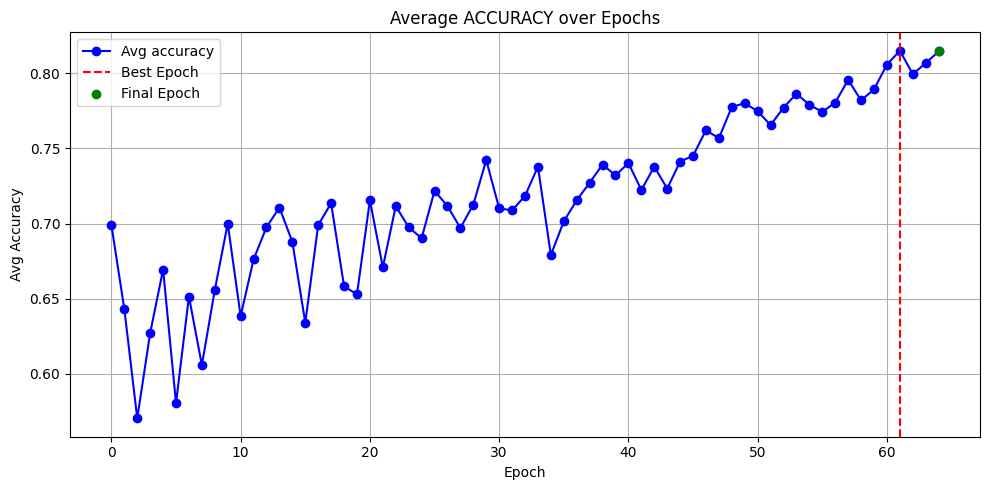


--- PRECISION ---
Final Epoch (64): 0.5338
Best Epoch  (64): 0.5338


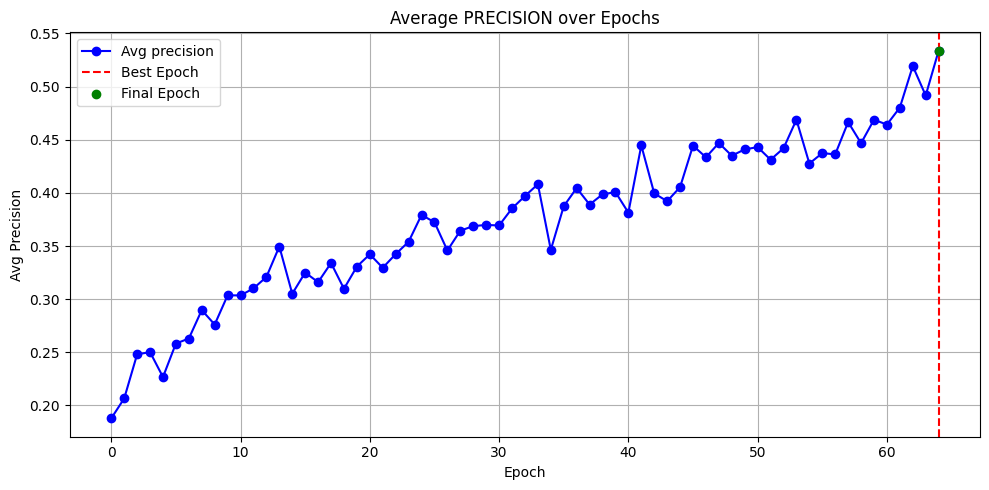


--- RECALL ---
Final Epoch (64): 0.5376
Best Epoch  (43): 0.5962


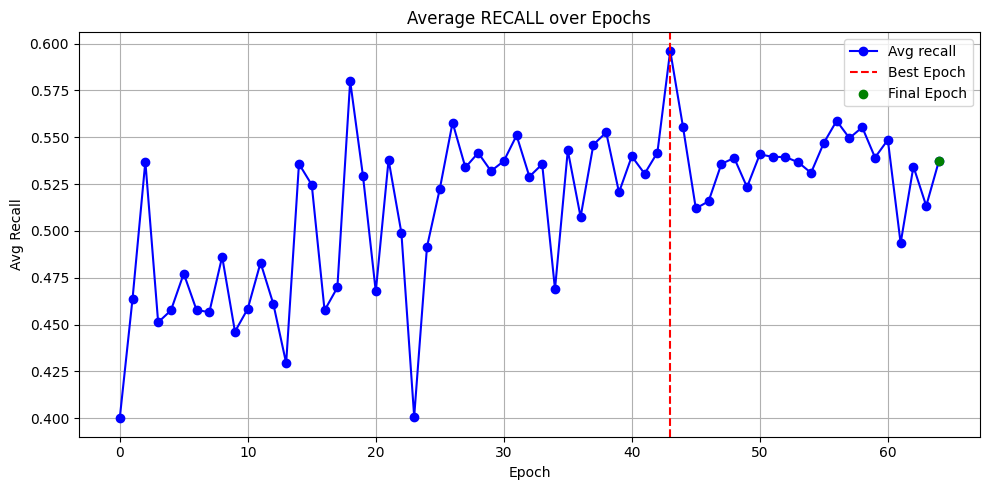


--- F1 ---
Final Epoch (64): 0.5153
Best Epoch  (64): 0.5153


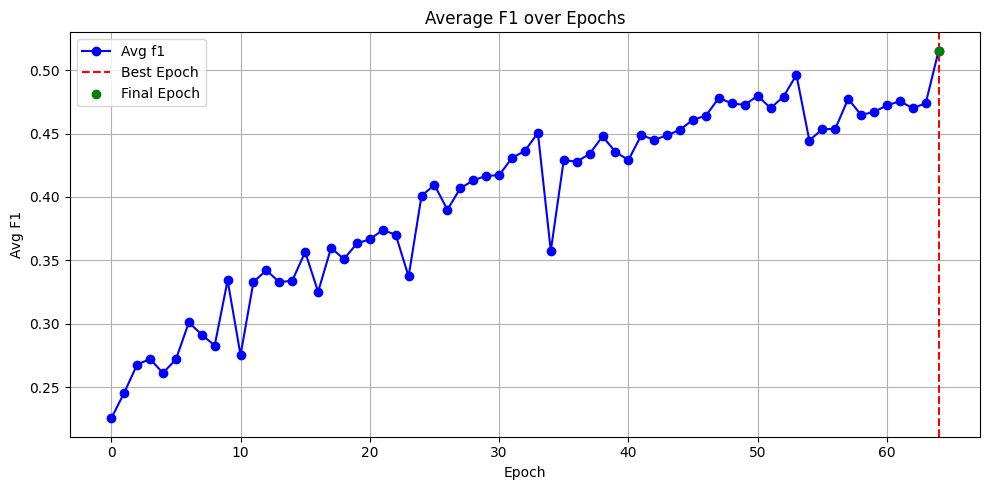


--- ROC_AUC ---
Final Epoch (64): 0.7495
Best Epoch  (62): 0.7590


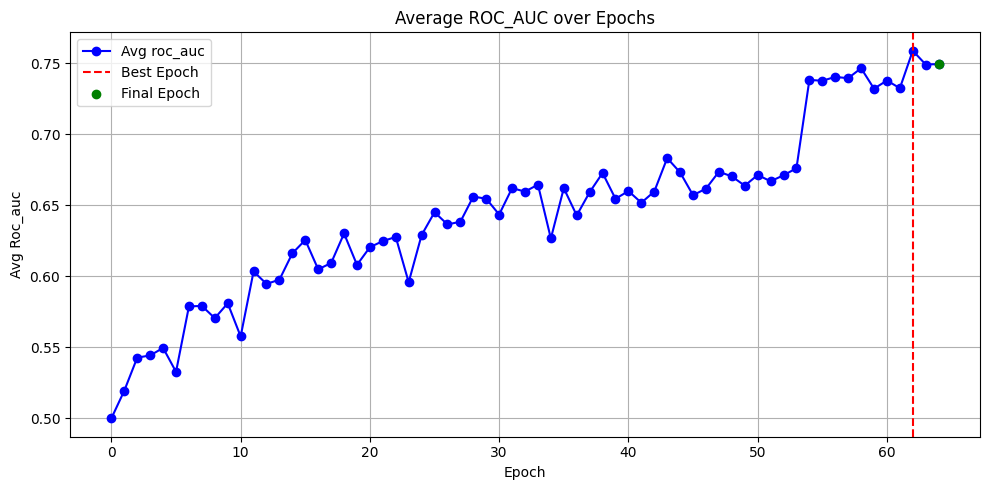

In [94]:
import numpy as np
import matplotlib.pyplot as plt

organs = ["bowel", "extra", "kidney", "liver", "spleen"]
metrics = ["accuracy", "precision", "recall", "f1", "roc_auc"]

for metric in metrics:
    # Gather all values per organ and stack as array
    all_values = [history["metrics"][organ][metric] for organ in organs]
    all_values = np.array(all_values)  # shape: (num_organs, num_epochs)
    
    # Compute average across organs per epoch
    avg_values = np.mean(all_values, axis=0)

    # Identify last epoch value and best epoch
    last_epoch = len(avg_values) - 1
    best_epoch = np.argmax(avg_values)
    best_value = avg_values[best_epoch]

    print(f"\n--- {metric.upper()} ---")
    print(f"Final Epoch ({last_epoch}): {avg_values[last_epoch]:.4f}")
    print(f"Best Epoch  ({best_epoch}): {best_value:.4f}")

    # Plot the average metric
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(avg_values)), avg_values, marker='o', color='blue', label=f"Avg {metric}")
    plt.axvline(best_epoch, color='red', linestyle='--', label='Best Epoch')
    plt.scatter(last_epoch, avg_values[last_epoch], color='green', zorder=5, label='Final Epoch')
    plt.title(f"Average {metric.upper()} over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel(f"Avg {metric.capitalize()}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

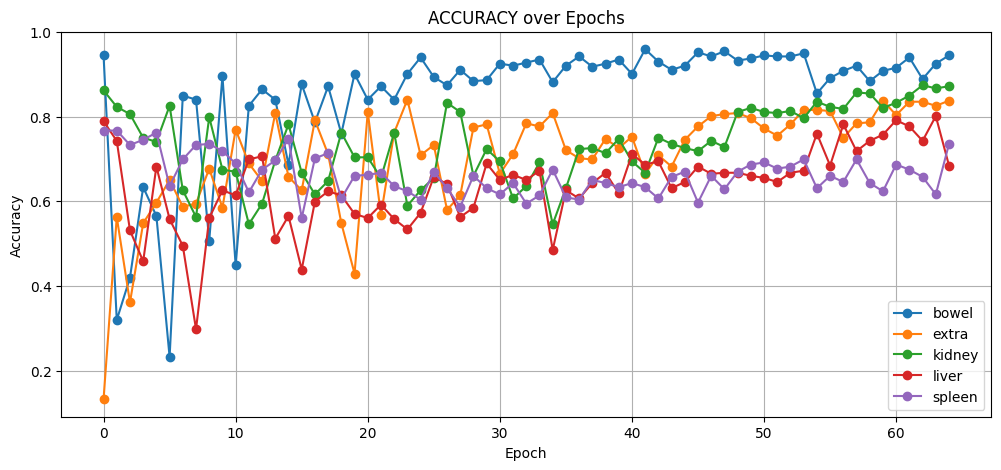

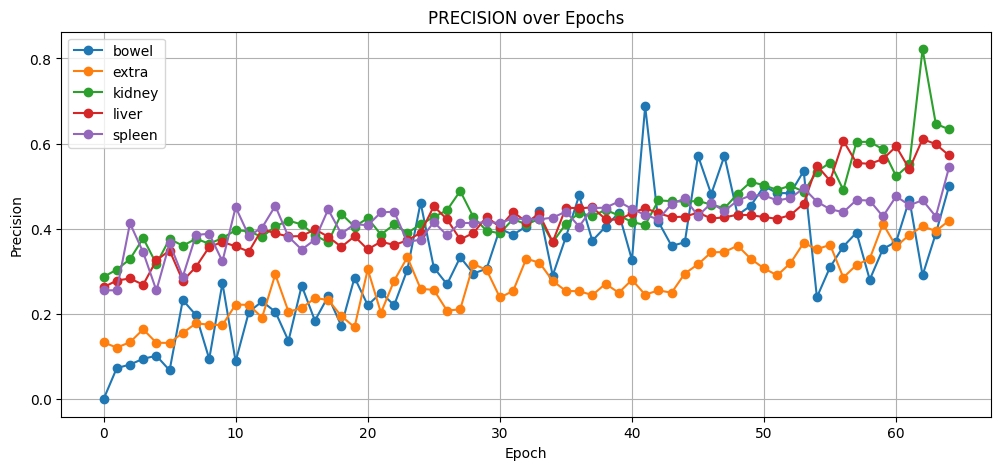

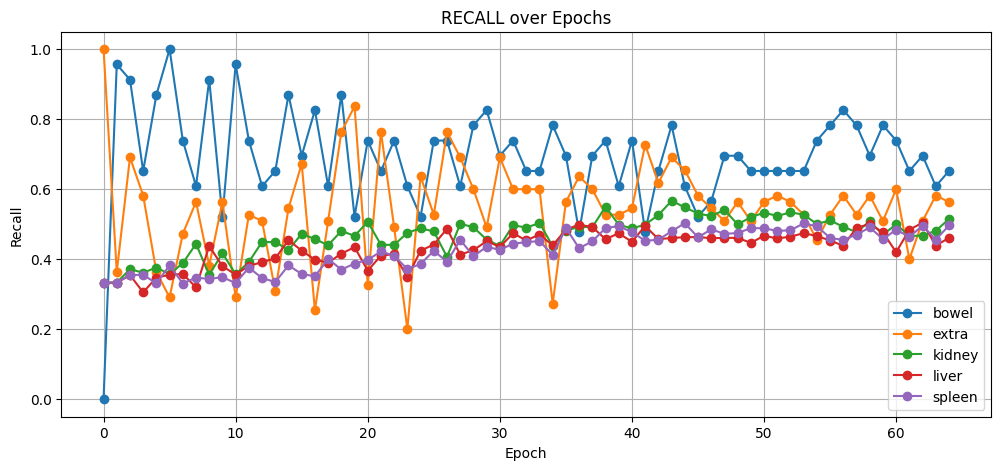

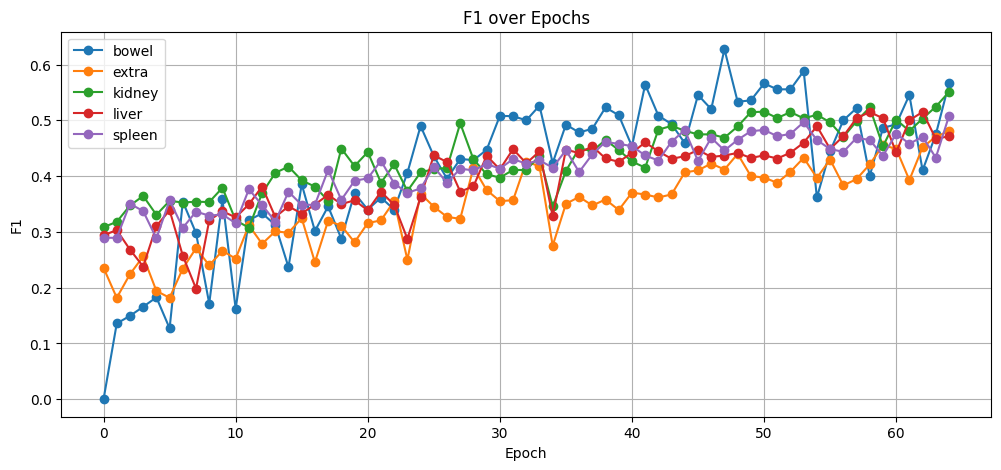

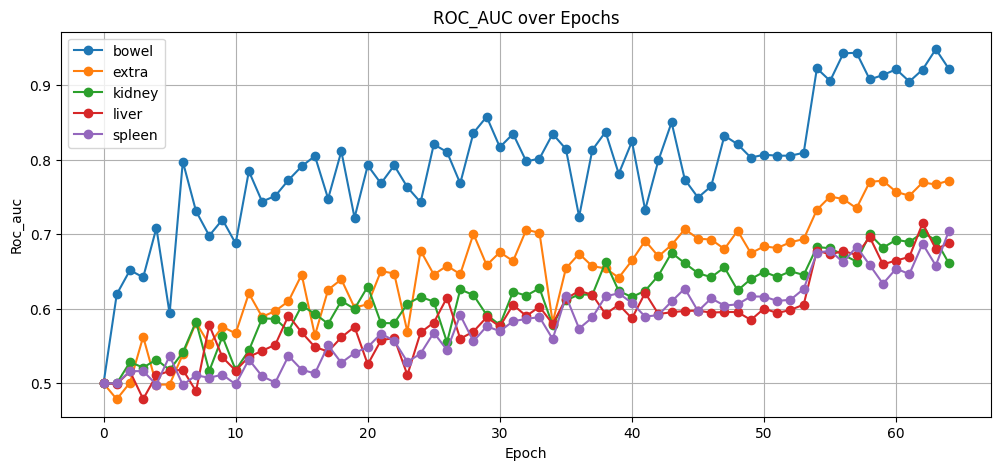

In [95]:
import matplotlib.pyplot as plt

organs = ["bowel", "extra", "kidney", "liver", "spleen"]
metrics = ["accuracy", "precision", "recall", "f1", "roc_auc"]

for metric in metrics:
    plt.figure(figsize=(12, 5))
    for organ in organs:
        values = history["metrics"][organ][metric]
        if len(values) == 1:
            # Plot a single point
            plt.plot(0, values[0], marker='o', label=organ)
        elif len(values) > 1:
            # Plot a line with markers
            plt.plot(range(len(values)), values, label=organ, marker='o')
    plt.title(f"{metric.upper()} over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

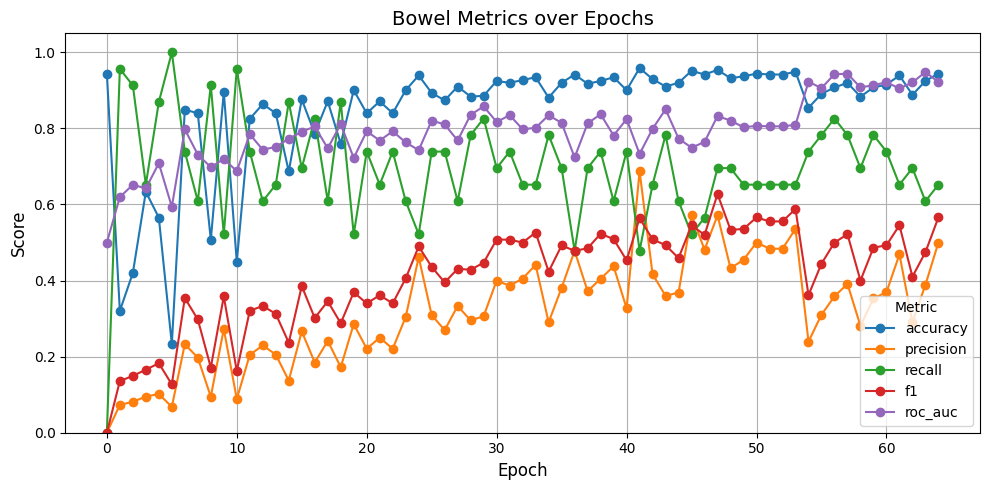

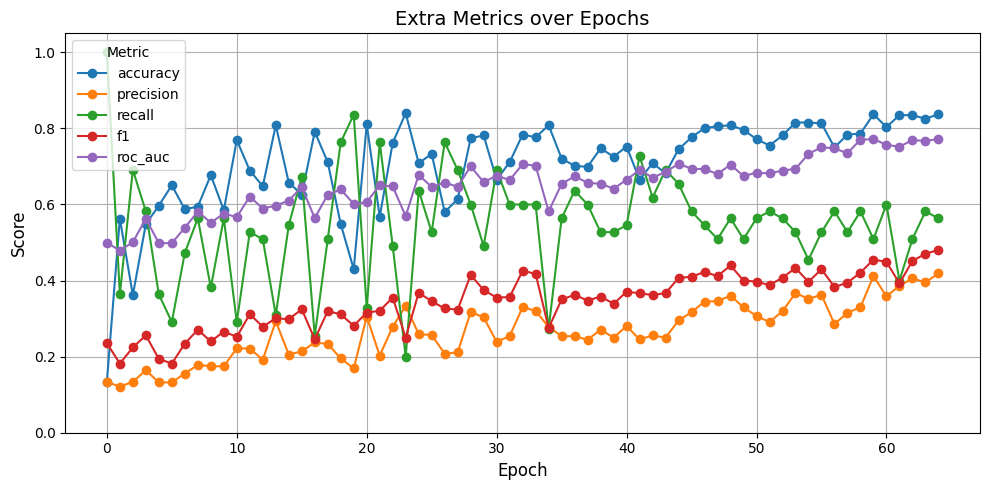

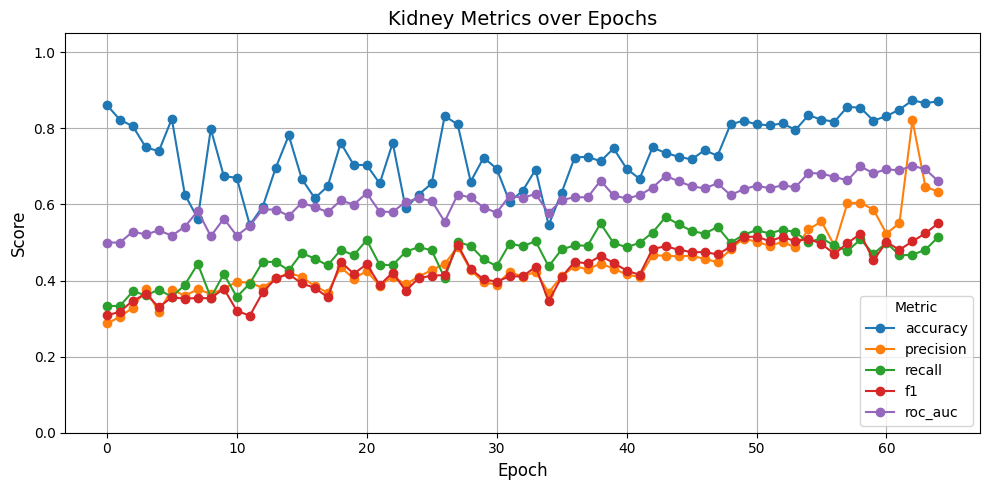

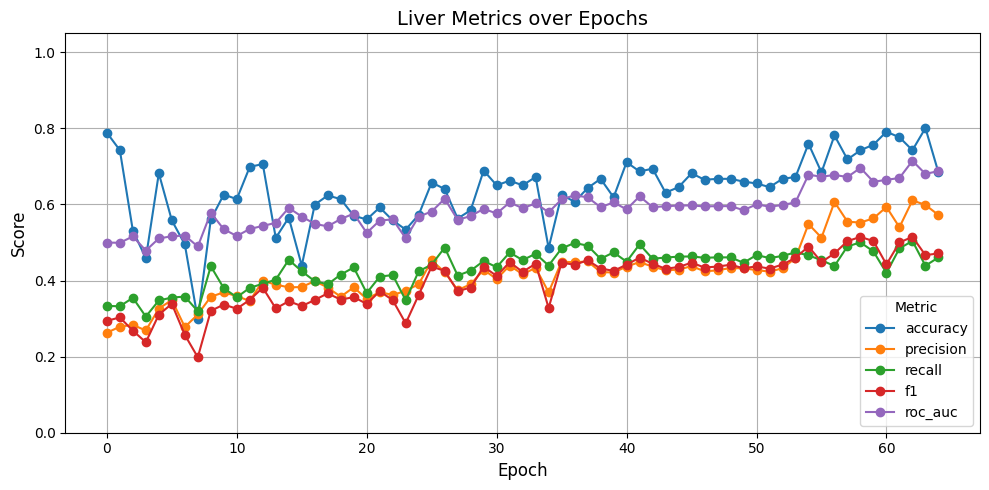

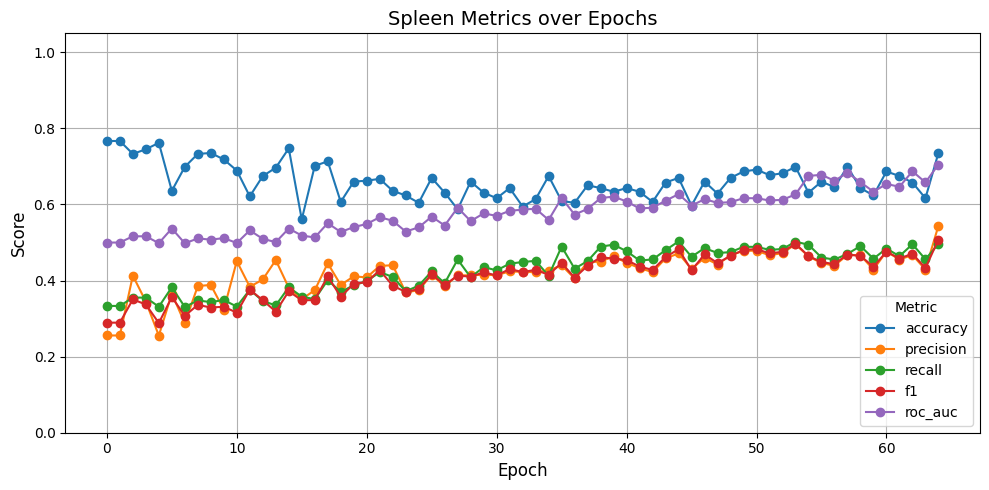

In [96]:
import matplotlib.pyplot as plt

organs = ["bowel", "extra", "kidney", "liver", "spleen"]
metrics = ["accuracy", "precision", "recall", "f1", "roc_auc"]

for organ in organs:
    plt.figure(figsize=(10, 5))

    for metric in metrics:
        values = history["metrics"][organ].get(metric, [])
        if values:
            plt.plot(range(len(values)), values, marker='o', label=metric)

    plt.title(f"{organ.capitalize()} Metrics over Epochs", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.ylim(0, 1.05)
    plt.legend(title="Metric")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [97]:
# Load the checkpoint
history = checkpoint["history"]

# Access metrics
metrics = history["metrics"]

# Number of epochs recorded
num_epochs = len(history["train_loss"])

# Print metrics per epoch
for epoch in range(num_epochs):
    print(f"\n📅 Epoch {epoch + 1}")
    for organ in metrics:
        print(f"🫁 Organ: {organ}")
        for metric_name in metrics[organ]:
            value = metrics[organ][metric_name][epoch]
            print(f"   {metric_name}: {value}")



📅 Epoch 1
🫁 Organ: bowel
   precision: 0.0
   recall: 0.0
   f1: 0.0
   roc_auc: 0.5
   accuracy: 0.9441747572815534
   train_loss: 1.6555417159508015
   val_loss: 0.9367686555935786
🫁 Organ: extra
   precision: 0.13349514563106796
   recall: 1.0
   f1: 0.2355460385438972
   roc_auc: 0.5
   accuracy: 0.13349514563106796
   train_loss: 1.207568567374657
   val_loss: 0.9668838748565087
🫁 Organ: kidney
   precision: 0.2872168284789644
   recall: 0.3333333333333333
   f1: 0.30856149500217295
   roc_auc: 0.5
   accuracy: 0.8616504854368932
   train_loss: 0.15135281719267368
   val_loss: 0.09222017400539838
🫁 Organ: liver
   precision: 0.26294498381877024
   recall: 0.3333333333333333
   f1: 0.2939846223428313
   roc_auc: 0.5
   accuracy: 0.7888349514563107
   train_loss: 0.14691406835255952
   val_loss: 0.10660033701704098
🫁 Organ: spleen
   precision: 0.255663430420712
   recall: 0.3333333333333333
   f1: 0.28937728937728935
   roc_auc: 0.5
   accuracy: 0.7669902912621359
   train_loss: 0

In [98]:
# import torch
# import matplotlib.pyplot as plt

# # Load checkpoint
# checkpoint_path = "/kaggle/input/densenet121-model/checkpoint.pth"
# checkpoint = torch.load(checkpoint_path, map_location="cpu", weights_only=False)
# history = checkpoint["history"]

# # Plot training and validation loss
# plt.figure(figsize=(10, 4))
# plt.plot(history["train_loss"], label="Train Loss")
# plt.plot(history["val_loss"], label="Validation Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Training & Validation Loss")
# plt.legend()
# plt.grid(True)
# plt.show()